# Getting the Cover Image and Secret Message

Secret Message:
Stegosaurus is a genus of thyreophoran dinosaur. Fossils of this genus date to the Late Jurassic period, where they are found in Kimmeridgian to early Tithonian aged strata, between 155 and 150 million years ago, in the western United States and Portugal. Several species have been classified in the upper Morrison Formation of the western U.S, though only three are universally recognized; S. stenops, S. ungulatus and S. sulcatus. The remains of over 80 individual animals of this genus have been found. Stegosaurus would have lived alongside dinosaurs such as Apatosaurus, Diplodocus, Brachiosaurus, Allosaurus, and Ceratosaurus; the latter two may have been predators of it.

Cover Image:


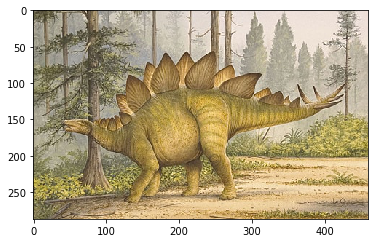

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

def file_to_string(file='./secret_message.txt'):
    s = ""
    with open(file, 'r') as f:
        for line in f:
            s += line
    return s

cover_img = cv2.imread('./img/cover1.jpg',1)
secret_message = file_to_string()

print("Secret Message:")
print(secret_message)

print("\nCover Image:")
plt.imshow(cv2.cvtColor(cover_img, cv2.COLOR_BGR2RGB))

# Metrics
We can use the scikit-image measurements in order to get values for MSE, PSNR, and SSIM. Reference: <http://scikit-image.org/docs/dev/api/skimage.measure.html>

In [ ]:
import skimage

# Basic LSB Steganography

S
Original: 1100011


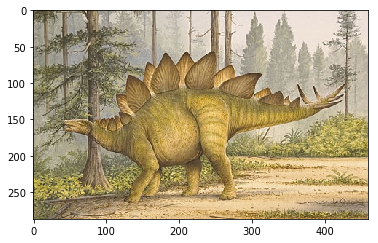

In [34]:
def basic_lsb_steg(img, message):
    stego = img.copy()
    it = np.nditer(stego, flags=['multi_index'], op_flags=['writeonly'])
    current_byte = message[0:1]
    print(current_byte)
    while not it.finished:
        i = it[0]
        print("Original:","{0:b}".format(int(i)))
        it[0] = 250
        it.iternext()
        break
    return stego

stego_img = basic_lsb_steg(cover_img, secret_message)
plt.imshow(cv2.cvtColor(stego_img, cv2.COLOR_BGR2RGB))